# Laboratorium 6 - Uczenie głębokie - segmentacja
## Techniki Obrazowania Medycznego - AGH 
**Kontakt: wodzinski@agh.edu.pl / MSTeams**

W trakcie laboratorium zostanie przedstawiony problem segmentacji obrazów medycznych na przykładzie segmentacji narzędzi w obrazach endoskopowych, wykorzystując algorytmy uczenia głębokiego.

Laboratorium można podzielić na następujące części:
<ul>
<li> Utworzenie pliku .csv zawierającego scieżki do zdjęć i odpowiadających im masek binarnych, podział na zbiory
<li> Utworzenie datasetu i dataloaderów do wczytywania odpowiedniego zbioru treningowego, walidacyjnego i testowego
<li> Implementacja bazowej sieci U-Net
<li> Nadzorowany trening sieci U-Net
<li> Analiza uzyskanych rezultatów na poszczególnych zbiorach danych
</ul>



## Część 1 - Utworzenie pliku .csv zawierającego informacje o zbiorze danych

Na ostatnich zajęciach dataloader tworzony był bezpośrednio zakładając zadaną strukture folderów. Na obecnych zajęciach dodamy dodatkowy krok poprzedzający - informacje o zbiorze danych zostaną automatycznie zebrane do pliku .csv, który następnie zostanie podzielony na zbiór treningowy, walidacyjny, oraz testowy. Takie podejście umożliwia łatwe łączenie zbiorów danych z różnych ośrodków. Wystarczy napisać proste skrypty przekształcające strukture zadanego zbioru danych do pożądanej reprezetancji i przygotować jedynie jeden, dedykowany dataset/dataloader.

Problem będziemy rozwiązywać na przykładzie segmentacji narzędzi w obrazach endoskopowych. Zbiór danych pochodzi ponownie z platformy Kaggle: https://www.kaggle.com/datasets/debeshjha1/kvasirinstrument
Obrazy endoskopowe zostały wybrane, ponieważ są to obrazy dwuwymiarowe, które w uproszczonej wersji problemu nie wymagają dużych mocy obliczeniowych. W praktyce obrazy endoskopowe są sekwencjami video, które muszą być przetwarzane w czasie rzeczywistym, co zdecydowanie komplikuje problem i nakłada dodatkowe ograniczenia.

Zbiór danych zawiera dwa foldery: images oraz masks, które zawierają odpowiednio zdjęcie endoskopowe oraz maske binarną wskazującą gdzie znajduje się narzędzie. Odpowiadające zdjęcia mają te same nazwy. W pierwszym kroku automatycznie stwórzmy i zapiszmy plik .csv zawierający pary: (scieżka do zdjęcia, ścieżka do maski binarnej).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48.4 MB 1.8 MB/s 


In [ ]:
#!unzip '/content/drive/My Drive/dat/kvasir.zip' -d '/content/drive/My Drive/dat/Data'

In [ ]:
import os
import pandas as pd

#data_path =r'C:/Users/PoiPon/Desktop/kvasir-instrument'

#data_path =r'/content/drive/My Drive/Data/kvasir-instrument'

data_path =r'/content/drive/My Drive/dat/Data/kvasir-instrument' # TODO Sciezka do rozpakowanego zbioru danych
csv_path = os.path.join(data_path, "dataset.csv") # Sciezka do pliku .csv, ktory zostanie utworzony

images_path = os.path.join(data_path, "images", "images")
masks_path = os.path.join(data_path, "masks", "masks")

images = os.listdir(images_path)
dataset = []
for image in images:
    image_path = os.path.join(images_path, image) # TODO - zbuduj sciezke do zadanego zdjecia #zmienic na format .png dla maski
    mask_path = os.path.join(masks_path, image.replace('.jpg', '.png')) # TODO - zbuduj sciezke do odpowiadajacej maski
    dataset.append([image_path, mask_path])

dataframe = pd.DataFrame(dataset, columns=["Image_Path", "Mask_Path"])
dataframe.to_csv(csv_path, index=False)

W drugim kroku dokonajmy podziału utworzonego pliku .csv na trzy oddzielnie pliki .csv, czyli na zbiór treningowy, walidacyjny, oraz testowy. Zbiór walidacyjny będzie używany w trakcie treningu do monitowania overfittingu, natomiast nie będzie wykorzystywany bezpośrednio do aktualizacji parametrów sieci. Dzięki temu można uzyskać na bieżąco informacje czy sieć nie zaczyna sie "przeuczać". Co prawda w folderze znajduje sie lista, które przypadki powinny być traktowane jako treningowe, a które jako testowe, zignorujmy to.

In [ ]:
input_csv_path = os.path.join(data_path, "dataset.csv")

training_csv_path =  os.path.join(data_path, "training_dataset.csv")# Sciezka do przypadkow treningowych
validation_csv_path = os.path.join(data_path, "validation_dataset.csv")# Sciezka do przypadkow walidacyjnych
testing_csv_path = os.path.join(data_path, "testing_dataset.csv") # Sciezka do przypadkow testowych

dataframe = pd.read_csv(input_csv_path)
split_ratio = (0.7, 0.1, 0.2) #70% - zbior treningowy, 10% - zbior walidacyjny, 20% - zbior testowy

from sklearn.model_selection import train_test_split
# TODO - dokonaj podzialu na zbior treningowy/walidacyjny/testowy
training_dataframe, testing_dataframe = train_test_split(dataframe, test_size=1-split_ratio[0])
validation_dataframe, testing_dataframe = train_test_split(testing_dataframe, test_size=split_ratio[2]/(split_ratio[2]+split_ratio[1]))

print(f"Dataframe size: {len(dataframe)}")
print(f"Training Dataframe size: {len(training_dataframe)}")
print(f"Validation Dataframe size: {len(validation_dataframe)}")
print(f"Testing Dataframe size: {len(testing_dataframe)}")

training_dataframe.to_csv(training_csv_path, index=False)
validation_dataframe.to_csv(validation_csv_path, index=False)
testing_dataframe.to_csv(testing_csv_path, index=False)

Dataframe size: 590
Training Dataframe size: 412
Validation Dataframe size: 59
Testing Dataframe size: 119


## Część 2 - Utworzenie dedykowanego datasetu i dataloadera

Podobnie jak w przypadku klasyfikacji, utworzymy dedykowany dataset do wczytywania zbioru danych. Tym razem, dzięki temu, że dokonaliśmy wstępnego utworzenia pliku .csv, implementacja dataloadera będzie dużo łatwiejsza.

In [ ]:
import os
import numpy as np
import pandas as pd
import torch as tc
import torchvision as tv
import matplotlib.pyplot as plt
import SimpleITK as sitk
from torchvision.transforms import ToTensor, Resize, Grayscale

import torch.nn.functional as F
from torch.nn.functional import interpolate


import torch.nn as nn


class EndoscopyDataset(tc.utils.data.Dataset):
    def __init__(self, data_path, csv_path):
        self.data_path = data_path # Sciezka zawierajaca zbior danych
        self.csv_path = csv_path # Sciezka do pliku csv zawierającego relatywne sciezki do poszczegolnych plikow
        self.dataframe = pd.read_csv(self.csv_path)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        current_case = self.dataframe.iloc[idx]
        image_path = os.path.join(self.data_path, current_case["Image_Path"])
        mask_path = os.path.join(self.data_path, current_case["Mask_Path"])

        image = sitk.GetArrayFromImage(sitk.ReadImage(image_path)).astype(np.float32)
        mask = sitk.GetArrayFromImage(sitk.ReadImage(mask_path)).astype(np.float32) 

        # Mimo tego, ze sa to maski binarne na potrzeby treningu chcemy typ zmiennoprzecinkowy

        image = (image - np.min(image)) / (np.max(image) - np.min(image)) 
        mask =  (mask - np.min(mask)) / (np.max(mask) - np.min(mask))

        image = ToTensor()(image)
        mask = ToTensor()(mask)

        mask = Grayscale(1)(mask)

        image = Resize((256,256))(image)
        mask = Resize((256,256))(mask)


        # TODO - dokonaj konwersji na tensor, normalizacji obu tensorow do 0-1 oraz 
        #resamplingu do rozdzielczosci 256 x 256 (wyjsciowy wymiar zdjecia 3x256x256, a maski 1x256x256)
        return image, mask



Dokonaj wizualizacji kilku przypadków ze zbioru testowego:

Dataset size: 119


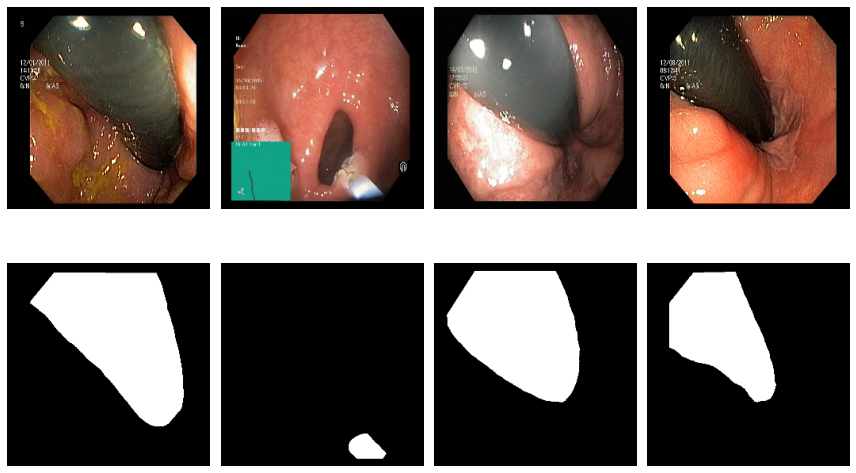

In [ ]:
testing_dataset = EndoscopyDataset(data_path, testing_csv_path)
batch_size = 4
print(f"Dataset size: {len(testing_dataset)}")
testing_dataloader = tc.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)

x, y = next(iter(testing_dataloader))

plt.figure(figsize=(12,8))

for i in range(batch_size):
  plt.subplot(2, 4, i+1)
  img1 = x[i]
  plt.imshow(img1.permute(1, 2, 0))
  plt.axis('off')

  plt.subplot(2, 4, i+5)
  img2 = y[i]
  plt.imshow(img2.permute(1, 2, 0).squeeze(axis=2), cmap="gray")
  plt.axis('off')

plt.tight_layout()

## Część 3 - Implementacja architektury U-Net

Przed przystąpieniem do dalszych kroków należy zapoznać się z:

Warsty konwolucyjne: https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/

Normalizacja: https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/

Funkcje aktywacji: https://www.section.io/engineering-education/activation-functions/


Przełomem w kontekście segmentacji obrazów medycznych, a później również algorytmów wizji komputerowej było zaproponowanie w 2015 na konferencji MICCAI architektury U-Net. Artykuł naukowy omawiający wspomnianą architekturę można znaleźć w: https://arxiv.org/pdf/1505.04597.pdf <- przed przystąpieniem do dalszej części zajęć należy go przeczytać.

Architektura U-Net jest przykładem architektury encodera-decodera, gdzie encoder ("lewa strona U") jest odpowiedzialny za stworzenie przestrzeni ukrytej zawierającej cechy umożliwiające wysegmentowanie zadanych struktur. Decoder ("prawa strona U") jest odpowiedzialny za przekształcenie reprezentacji w przestrzeni ukrytej (tzw. embedding / latent space) z powrotem do wymiarów zdjęcia pierwotnego, jednak tym razem reprezentując maskę binarną, a nie zdjęcie oryginalne.

Architektura U-Net zawiera trzy krytyczne struktury, które spowodowały jej sukces w kontekście segmentacji, a następnie również w wielu innych zastosowaniach (dopasowania, rekonstrukcji, detekcji..).

<ul>
<li> Wykorzystanie warstw max-pool w kontekście zmniejszania rozdzielczości reprezentacji na kolejnych poziomach piramidy i tym samym zwiększenie tzw. receptive field. Czym jest i jak wyznaczyć receptive field: https://www.baeldung.com/cs/cnn-receptive-field-size. Wielkość receptive field jest kluczowa w trakcie projektowania dowolnych sieci neuronowych. Należy tak zaprojektować architekture aby sieć była w stanie ocenić kontekst globalny, tj. żeby parametry pochodzące z wszystkich miejsc w obrazie były wzajemnie połączone. Niestety, lokalna charakterystyka operacji konwolucji nie umożliwia pełnej realizacji tego założenia, w związku z czym powstały takie architektury jak np. Vision Transformer (który nie będzie omawiany na tym przedmiocie). Niemniej, sieci konwolucyjne są bardzo dobrym narzędziem do wielu zastosowań, szczególnie tych, dla których globalne zależności nie są kluczowe jak np. segmentacja narzędzi chirurgicznych.
<li> Wprowadzenie skip-connections między poszczególnymi poziomami architektury. Dzięki temu jest możliwe zdecydowane zwiększenie receptive field oraz ograniczenie problemu zanikającego gradientu. Bezpośrednie połączenie wyższych poziomów encodera z decoderem umożliwia połączenie i utrzymanie wzajemnej relacji między filtrami (cechami) w poszczególnych warstwach.
<li> Zastosowanie tzw. dekonwolucji (konwolucji transponowanej) w dekoderze. Dzięki temu możliwe jest nauczenie sieci filtrów zwiększających rozdzielczość poszczególnych reprezentacji i uzyskanie precyzyjnych masek binarnych na wyjściu. Można je potraktować jako nauczoną interpolacje nieliniową.
</ul> 

W kolejnym kroku, bazując na poprzednim laboratorium oraz wspomnianym artykule, dokonaj implementacji sieci U-Net, z jedną modyfikacją: spraw by rozdzielczość tensora wyjściowego była taka sama jak rozdzielczość tensora wejściowego (3x256x256 -> 1x256x256). Można tego dokonać stosując odpowiedni padding w poszczególnych warstwach konwolucyjnych/dekonwolucyjnych. Uwaga - podobnie jak w trakcie poprzedniego laboratorium, dodaj warstwy BatchNorm2D


In [ ]:
class Block(tc.nn.Module):
    def __init__(self, in_ch, out_ch, convtrans=False):
        super().__init__()

        self.layer = tc.nn.Sequential(
            tc.nn.Conv2d(in_ch, out_ch, 3, padding=1), 
            tc.nn.BatchNorm2d(out_ch),
            tc.nn.ReLU(inplace=True),
            tc.nn.Conv2d(out_ch, out_ch, 3, padding=1),
            tc.nn.BatchNorm2d(out_ch),
            tc.nn.ReLU(inplace=True)
        ) 

        self.conv = tc.nn.ConvTranspose2d(in_ch, out_ch, 2, 2)
        self.convtrans = convtrans

    def forward(self, x):
      if self.convtrans:
        x = self.conv(x)
        return x
      else:
        x = self.layer(x)
        return x



class UNet(tc.nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.enc1 = Block(3, 64)
        self.enc2 = Block(64, 128)
        self.enc3 = Block(128, 256)
        self.enc4 = Block(256, 512)
        self.enc5 = Block(512, 1024)

        self.pool = tc.nn.MaxPool2d(2, 2)

        self.dec1 = Block(1024, 512, convtrans=True)
        self.dec2 = Block(1024, 512)
        self.dec3 = Block(512, 256, convtrans=True)
        self.dec4 = Block(512, 256)
        self.dec5 = Block(256, 128, convtrans=True)
        self.dec6 = Block(256, 128)
        self.dec7 = Block(128, 64, convtrans=True)
        self.dec8 = Block(128, 64)

        self.last = tc.nn.Sequential(
             tc.nn.Conv2d(64, 1, 1),
             tc.nn.Sigmoid()
        )

    def forward(self, x):

        x1 = self.enc1(x) 
        x2 = self.pool(x1) 
        x3 = self.enc2(x2) 
        x4 = self.pool(x3) 
        x5 = self.enc3(x4) 
        x6 = self.pool(x5) 
        x7 = self.enc4(x6) 
        x8 = self.pool(x7) 
        x9 = self.enc5(x8) 

        y1 = self.dec1(x9) 
        y2 = self.dec2(tc.cat([y1, x7], 1))  
        y3 = self.dec3(y2) 
        y4 = self.dec4(tc.cat([y3, x5], 1))  
        y5 = self.dec5(y4) 
        y6 = self.dec6(tc.cat([y5, x3], 1))  
        y7 = self.dec7(y6) 
        y8 = self.dec8(tc.cat([y7, x1], 1)) 
        x = self.last(y8)  
        return x

Następnie spraw działanie sieci na losowych zdjęciach wejściowych:

Images size: torch.Size([3, 256, 256])
Masks size: torch.Size([1, 256, 256])
Outputs size: torch.Size([1, 256, 256])


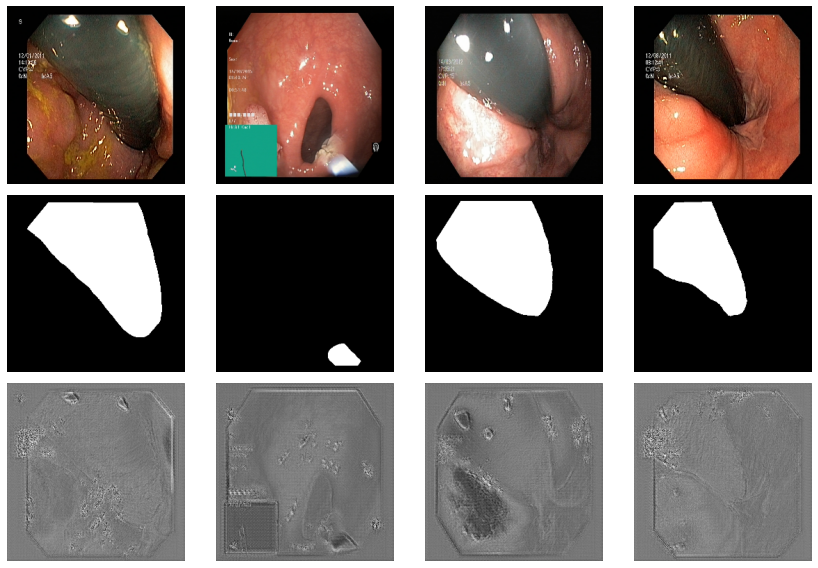

In [ ]:
model = UNet()

plt.figure(figsize=(12,8))

images, masks = next(iter(testing_dataloader))

outputs = model(images)

print("Images size:",images[0].shape)
print("Masks size:", masks[0].shape)
print("Outputs size:", outputs[0].shape)

batch_size = 4

for i in range(batch_size):
    plt.subplot(3, 4, i+1)
    img1 = images[i]
    plt.imshow(img1.permute(1, 2, 0))
    plt.axis('off')

    plt.subplot(3, 4, i+5)
    img2 = masks[i]
    plt.imshow(img2.permute(1, 2, 0).squeeze(axis=2), cmap="gray")
    plt.axis('off')

    plt.subplot(3, 4, i+9)
    img3 = outputs[i]
    plt.imshow(img3.detach().permute(1, 2, 0).squeeze(axis=2), cmap="gray")
    plt.axis('off')

plt.tight_layout() 

# Dokonaj wizualizacji widocznej ponizej (1 wiersz - zdjecia, 2 wiersz - ground-truth, 3 wiersz - wynik dzialania sieci)

Zgodnie z oczekiwaniami sieć jeszcze nie działa - nie została wytrenowana. Niemniej, wymiary wejścia i wyjścia zgadzają się z oczekiwanymi. Kolejnym krokiem będzie trening zaimplementowanej sieci.

## Część 4 - Trening sieci segmentacyjnej

Problem segmentacji możemy potraktować jako klasyfikację poszczególnych pikseli/voxeli. W związku z tym możliwe jest wykorzystanie funkcji entropijnych do treningu algorytmów segmentacji. Alternatywnie, możliwe jest wprost wykorzystanie współczynnika Dice'a w wersji różniczkowalnej (patrz: ewaluacja projektu). W trakcie tego laboratorium wykorzystamy bezpośrednio tzw. Soft Dice Loss. Pozostałe elementy pętli treningowej są analogicznie jak na poprzednich zajęciach (uczenie nadzorowane), jedyne różnice to fakt występowania zbioru walidacyjnego oraz używanie obrazów binarnych jako ground-truth zamiast zakodowanej klasy.

W kolejnym kroku zaimplementuj pętle uczącą i dokonaj treningu zaimplementowanej sieci:

In [ ]:
# Ponizej analogicznie jak na poprzednich zajeciach
learning_rate = 0.003
model = UNet()
batch_size = 16
num_epochs = 5
parameters = model.parameters()
optimizer = tc.optim.Adam(parameters, lr=learning_rate)
device = "cuda:0"

def dice_loss(prediction, target):
    smooth = 1
    prediction = prediction.contiguous().view(-1)
    target = target.contiguous().view(-1)
    intersection = tc.sum(prediction * target)
    return 1 - ((2 * intersection + smooth) / (prediction.sum() + target.sum() + smooth))

objective_function = dice_loss

training_dataset = EndoscopyDataset(data_path, training_csv_path)
validation_dataset = EndoscopyDataset(data_path, validation_csv_path)

shuffle = True 

training_dataloader = tc.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=shuffle)
validation_dataloader = tc.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

Training Dataset size: 412
Validation Dataset size: 59
Current epoch: 0
Current training epoch loss: 0.4758680590148111
Current validation epoch loss: 0.7121252508486732
Current epoch: 1
Current training epoch loss: 0.2825860091783468
Current validation epoch loss: 0.29449570583084883
Current epoch: 2
Current training epoch loss: 0.23987136535274173
Current validation epoch loss: 0.21558261826886968
Current epoch: 3
Current training epoch loss: 0.20651436893685352
Current validation epoch loss: 0.29186944941342885
Current epoch: 4
Current training epoch loss: 0.20607717233954123
Current validation epoch loss: 0.19030763739246434


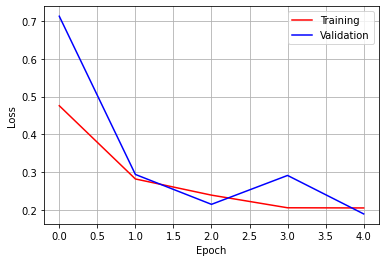

In [ ]:
training_losses = []
validation_losses = []

model = model.to(device)

print(f"Training Dataset size: {len(training_dataloader.dataset)}")
print(f"Validation Dataset size: {len(validation_dataloader.dataset)}")


for epoch in range(num_epochs):
    print(f"Current epoch: {epoch}")
    
    training_epoch_loss = 0.0
    model.train()
    for images, masks in training_dataloader:

        optimizer.zero_grad()

        images, masks = images.to(device), masks.to(device)
        output = model(images)

        loss = objective_function(output,masks)
        loss.backward()

        optimizer.step()

        training_epoch_loss += loss.item() * images.size(0)


    training_epoch_loss = training_epoch_loss / len(training_dataloader.dataset)
    training_losses.append(training_epoch_loss)
    
    validation_epoch_loss = 0.0
    model.eval()
    with tc.set_grad_enabled(False):
        validation_epoch_loss = 0.0
        for images, masks in validation_dataloader:

            images, masks = images.to(device), masks.to(device)

            output = model(images)                                

            loss = objective_function(output, masks)   

            validation_epoch_loss += loss.item() * images.size(0)

        validation_epoch_loss = validation_epoch_loss / len(validation_dataloader.dataset)
        validation_losses.append(validation_epoch_loss)

    print(f"Current training epoch loss: {training_epoch_loss}")
    print(f"Current validation epoch loss: {validation_epoch_loss}")
    tc.cuda.empty_cache()

# Wizualizacja pętli treningowej
plt.figure()
plt.plot(training_losses, "r-")
plt.plot(validation_losses, "b-")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training", "Validation"])
plt.grid(True)
plt.show()


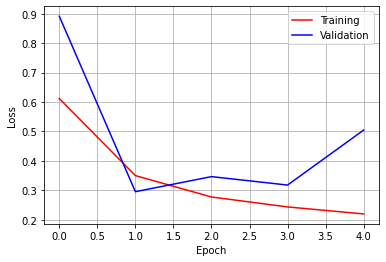

In [ ]:
# Wizualizacja pętli treningowej
plt.figure()
plt.plot(training_losses, "r-")
plt.plot(validation_losses, "b-")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training", "Validation"])
plt.grid(True)
plt.show()

## Część 5 - Ilościowa i jakościowa analiza wyników

Działanie algorytmów segmentacji obrazów medycznych ocenianie jest najcześciej wykorzystując współczynnik Dice'a oraz odległość Hausdorffa. Pierwsza wielkość mówi o zgodności objętościowej, druga o zgodności krawędzi. Oba sposoby ewaluacji są komplementarne i powinny być wykorzystywane razem.

Poniżej znajdują sie implementacje współczynnika Dice'a oraz miary Hausdorffa:

In [ ]:
from scipy.ndimage import _ni_support
from scipy.ndimage.morphology import distance_transform_edt, binary_erosion, generate_binary_structure
from glob import glob


#dice do ewaluacji inny niz do treningu

def dc(input1, input2):
    input1 = np.atleast_1d(input1)
    input2 = np.atleast_1d(input2)
    #intersection = np.count_nonzero(input1 & input2) 
    intersection = np.count_nonzero(np.logical_and(input1,input2))
    size_i1 = np.count_nonzero(input1)
    size_i2 = np.count_nonzero(input2)
    try:
        dc = 2. * intersection / float(size_i1 + size_i2)
    except ZeroDivisionError:
        dc = 0.0
    return dc

def __surface_distances(result, reference, voxelspacing=None, connectivity=1):
    result = np.atleast_1d(result)
    reference = np.atleast_1d(reference)
    if voxelspacing is not None:
        voxelspacing = _ni_support._normalize_sequence(voxelspacing, result.ndim)
        voxelspacing = np.asarray(voxelspacing, dtype=np.float64)
        if not voxelspacing.flags.contiguous:
            voxelspacing = voxelspacing.copy()
    footprint = generate_binary_structure(result.ndim, connectivity)
    if 0 == np.count_nonzero(result): 
        raise RuntimeError('The first supplied array does not contain any binary object.')
    if 0 == np.count_nonzero(reference): 
        raise RuntimeError('The second supplied array does not contain any binary object.')    
    result_border = result ** binary_erosion(result, structure=footprint, iterations=1)
    reference_border = reference ** binary_erosion(reference, structure=footprint, iterations=1)
    print(type(reference_border))
    dt = distance_transform_edt(~(reference_border.astype(int)), sampling=voxelspacing).astype(int)
    sds = dt[result_border.astype(int)]
    return sds

def hd95(result, reference, voxelspacing=None, connectivity=1):
    hd1 = __surface_distances(result, reference, voxelspacing, connectivity)
    hd2 = __surface_distances(reference, result, voxelspacing, connectivity)
    hd95 = np.percentile(np.hstack((hd1, hd2)), 95)
    return hd95


Wykorzystaj je aby dokonać ewaluacji odpowiednio zbioru treningowego, walidacyjnego oraz testowego.

In [ ]:
#tu nie wiem co się dzieje, ale nie działa ten hd95

optimizer.zero_grad()
batch_size = 4
training_dataset = EndoscopyDataset(data_path, training_csv_path)
validation_dataset = EndoscopyDataset(data_path, validation_csv_path)
testing_dataset = EndoscopyDataset(data_path, testing_csv_path)

training_dices = []
validation_dices = []
testing_dices = []
training_hds95 = []
validation_hds95 = []
testing_hds95 = []


model.eval()
with tc.set_grad_enabled(False):
    for images, masks in training_dataloader:

        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        #outputs = np.int_(np.rint(outputs.cpu().numpy())) 
        #masks = np.int_(np.rint(masks.cpu().numpy())) 
        #training_dices.append(dc(outputs, masks)) 

        training_dices.append(dc(outputs.cpu(), masks.cpu()))

        #training_hds95.append(hd95(outputs.cpu(), masks.cpu()))

        # TODO - Wyznacz i dokonaj agregacji DSC, HD95 dla wszystkich przypadkow 

    for images, masks in validation_dataloader:

        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        #outputs = np.int_(np.rint(outputs.cpu().numpy())) 
        #masks = np.int_(np.rint(masks.cpu().numpy())) 
        #validation_dices.append(dc(outputs, masks)) 


        validation_dices.append(dc(outputs.cpu(), masks.cpu()))
        #validation_hds95.append(hd95(outputs, masks))

        # TODO - Wyznacz i dokonaj agregacji DSC, HD95 dla wszystkich przypadkow 

    for images, masks in testing_dataloader:

        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        #outputs = np.int_(np.rint(outputs.cpu().numpy())) 
        #masks = np.int_(np.rint(masks.cpu().numpy())) 
        #testing_dices.append(dc(outputs, masks)) 


        testing_dices.append(dc(outputs.cpu(), masks.cpu()))
        #testing_hds95.append(hd95(outputs, masks))

        # TODO - Wyznacz i dokonaj agregacji DSC, HD95 dla wszystkich przypadkow 

print(f"Training Dice Mean: {np.array(training_dices).mean()}")
print(f"Training Dice Std: {np.array(training_dices).std()}")
print(f"Training Dice Min: {np.array(training_dices).min()}")
print(f"Training Dice Max: {np.array(training_dices).max()}")

print(f"Validation Dice Mean: {np.array(validation_dices).mean()}")
print(f"Validation Dice Std: {np.array(validation_dices).std()}")
print(f"Validation Dice Min: {np.array(validation_dices).min()}")
print(f"Validation Dice Max: {np.array(validation_dices).max()}")

print(f"Testing Dice Mean: {np.array(testing_dices).mean()}")
print(f"Testing Dice Std: {np.array(testing_dices).std()}")
print(f"Testing Dice Min: {np.array(testing_dices).min()}")
print(f"Testing Dice Max: {np.array(testing_dices).max()}")

print()

print(f"Training HD95 Mean: {np.array(training_hds95).mean()}")
print(f"Training HD95 Std: {np.array(training_hds95).std()}")
print(f"Training HD95 Min: {np.array(training_hds95).min()}")
print(f"Training HD95 Max: {np.array(training_hds95).max()}")

print(f"Validation HD95 Mean: {np.array(validation_hds95).mean()}")
print(f"Validation HD95 Std: {np.array(validation_hds95).std()}")
print(f"Validation HD95 Min: {np.array(validation_hds95).min()}")
print(f"Validation HD95 Max: {np.array(validation_hds95).max()}")

print(f"Testing HD95 Mean: {np.array(testing_hds95).mean()}")
print(f"Testing HD95 Std: {np.array(testing_hds95).std()}")
print(f"Testing HD95 Min: {np.array(testing_hds95).min()}")
print(f"Testing HD95 Max: {np.array(testing_hds95).max()}")


Training Dice Mean: 0.938494159866627
Training Dice Std: 0.07635965385580204
Training Dice Min: 0.029238723480121232
Training Dice Max: 0.9895622092329714
Validation Dice Mean: 0.9205365846524327
Validation Dice Std: 0.06238442512176274
Validation Dice Min: 0.6840888888888889
Validation Dice Max: 0.9742774566473988
Testing Dice Mean: 0.8823524754843132
Testing Dice Std: 0.1470247676619844
Testing Dice Min: 0.11320179782128438
Testing Dice Max: 0.9778508145184338

Training HD95 Mean: 6.668692018048566
Training HD95 Std: 13.27058508830459
Training HD95 Min: 1.0
Training HD95 Max: 108.5679506814086
Validation HD95 Mean: 16.1291756027929
Validation HD95 Std: 25.467325459474736
Validation HD95 Min: 2.0
Validation HD95 Max: 128.0723253572502
Testing HD95 Mean: 18.004489373991714
Testing HD95 Std: 28.848305798451666
Testing HD95 Min: 2.0
Testing HD95 Max: 158.01166805588872


Dokonaj również wizualizacji jakościowej pokazanej niżej (pokazanie obok siebie przykładowych zdjęć, ground-truth oraz wyznaczonych masek segmentacyjnych).

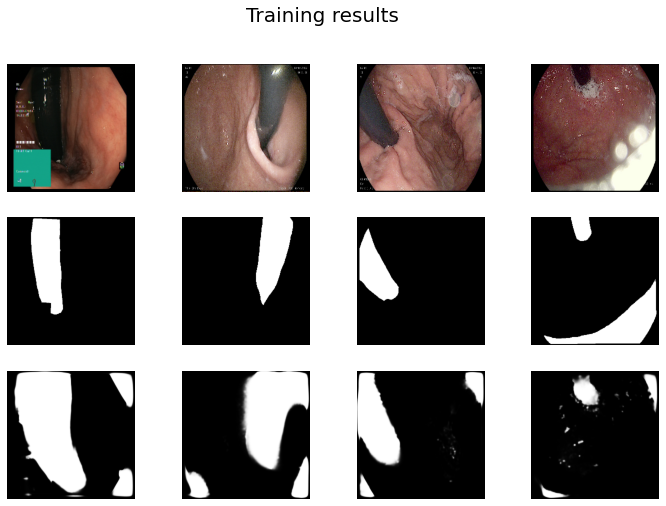

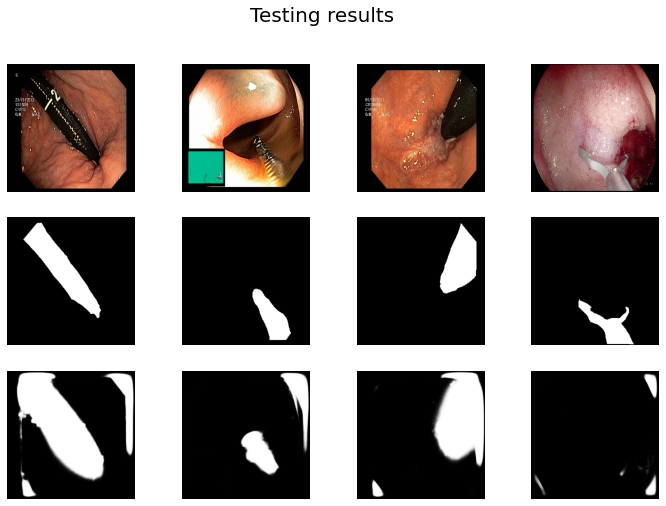

In [ ]:
plt.figure(figsize=(12,8))
plt.suptitle("Training results", fontsize=20)

images, masks = next(iter(training_dataloader))
images, masks = images.to(device), masks.to(device)
outputs = model(images)   

for i in range(4):
    plt.subplot(3, 4, i+1)
    img1 = images[i]
    plt.imshow(img1.cpu().permute(1, 2, 0))
    plt.axis('off')

    plt.subplot(3, 4, i+5)
    img2 = masks[i]
    plt.imshow(img2.cpu().permute(1, 2, 0).squeeze(axis=2), cmap="gray")
    plt.axis('off')

    plt.subplot(3, 4, i+9)
    img3 = outputs[i]
    plt.imshow(img3.cpu().detach().permute(1, 2, 0).squeeze(axis=2), cmap="gray")
    plt.axis('off')

plt.show() 


plt.figure(figsize=(12,8))
plt.suptitle("Testing results", fontsize=20)

images, masks = next(iter(testing_dataloader))  
images, masks = images.to(device), masks.to(device) 

outputs = model(images)

for i in range(4):
    plt.subplot(3, 4, i+1)
    img1 = images[i]
    plt.imshow(img1.cpu().permute(1, 2, 0))
    plt.axis('off')

    plt.subplot(3, 4, i+5)
    img2 = masks[i]
    plt.imshow(img2.cpu().permute(1, 2, 0).squeeze(axis=2), cmap="gray")
    plt.axis('off')

    plt.subplot(3, 4, i+9)
    img3 = outputs[i]
    plt.imshow(img3.cpu().detach().permute(1, 2, 0).squeeze(axis=2), cmap="gray")
    plt.axis('off')

plt.show() 

Jak widać - wyniki na zbiorze testowym są mocno nieidealne. Jest to związane zarówno z charakterystyką zbioru danych jak i z architekturą oraz sposobem treningu.